In [4]:
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as spi
import scipy.optimize as spo
%matplotlib inline
import os

### Download a file (Wolf/Moose populations from Isle Royale) and work with it in Pandas

In [8]:
dataurl='http://www.isleroyalewolf.org/sites/default/files/documents/isleroyale_graph_data_28Dec2011.xlsx'
datafile = 'isleroyale.xlsx'
if not os.path.exists(datafile):
    print('Pulling down {} from the internet'.format(datafile))
    urllib.request.urlretrieve(dataurl,'isleroyale.xlsx')
else:
    print('{} already downloaded: using local copy'.format(datafile))

isleroyale.xlsx already downloaded: using local copy


#### you can read the file we downloaded above

In [9]:
df = pd.read_excel(datafile,sheetname='data', skiprows=1, parse_cols='A:C', index_col=0, na_values='--')

In [10]:
df_all = pd.read_excel(datafile,sheetname='data', skiprows=1,index_col=0, na_values='--')

In [11]:
df_all.columns

Index(['wolf abundance', 'moose abundance', 'wolves/ 1000km2', 'moose/ km2',
       'wolf population growth rate', 'wolf mortality rate',
       'wolf recruitment rate', 'wolf inbreeding coefficient',
       'moose population growth rate', 'moose recruitment rate',
       'no. of old moose', 'ave age', 'kill rate (kills/wolf/month)',
       'ann predation rate', 'proportion of diet comprised of calves',
       'North Atlantic Oscillation (Dec-Mar;  Station Based Index)',
       'North Atlantic Oscillation (Dec-Mar; PC Based NAO Index)',
       'July-Sept (temp)', 'Apr-May (temp)', 'Jan-Feb temp',
       'may-aug (precip)', 'snow depth',
       'Growing degree days by Julian day 91 ',
       'Growing degree days by Julian day 105 ',
       'Growing degree days by Julian day 121',
       'Growing degree days by Julian day 135 ',
       'Growing degree days by Julian day 152 ',
       'Growing degree days by Julian day 166 ', 'Jan-Mar (precip)',
       'Dec-Apr (precip)', 'Unnamed: 31', '

In [12]:
try:
    df_web = pd.read_excel(dataurl,sheetname='data', skiprows=1, parse_cols='A:C', index_col=0)
except:
    print("Must not be online --- couldn't fetch the Excel file")

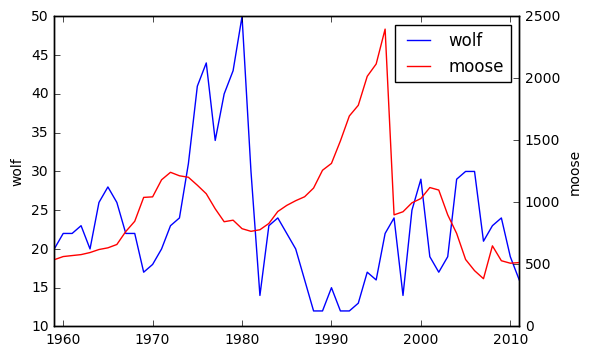

In [13]:
fig, ax = plt.subplots()
ax2=ax.twinx()
wl = ax.plot(df.index,df['wolf abundance'],label='wolf')
ml = ax2.plot(df.index, df['moose abundance'],color='r',label='moose')
ax.set_ylabel('wolf')
ax2.set_ylabel('moose')
plt.xlim([np.min(df.index.values),np.max(df.index.values)])
lns=wl + ml
labs = [l.get_label() for l in lns]
ax.legend(lns,labs)

## Now we can look at Owls across the US from the audobon bird counts (b/c why not?)
We will pull down the data and join it for the years in common

In [16]:
birdfile='HistoricalResultsbySpecies.csv'
indfBirds = pd.read_csv(os.path.join('data',birdfile))

In [17]:
# quick convert from Audobon year to calendar year
indfBirds['cal_year'] = indfBirds.Count_yr + 1899

In [18]:
indfBirds.head()

,﻿COM_NAME,SPECIES_CODE,Count_yr,SpeciesNumber,NumberByPartyHours,ReportingCounts,ReportingObservers,cal_year
0,Barred Owl,brdowl,1,1,0.0,1,1,1900
1,Barred Owl,brdowl,3,2,0.0,2,1,1902
2,Barred Owl,brdowl,4,1,0.0,1,2,1903
3,Barred Owl,brdowl,6,2,0.0,3,1,1905
4,Barred Owl,brdowl,7,4,0.0,4,2,1906


### Let's just grab the barred owl

In [19]:
bowl_df = indfBirds.loc[indfBirds.SPECIES_CODE == 'brdowl']

### now just pull the overlapping years with `merge`

In [20]:
df2=df.merge(bowl_df, left_index=True,right_on='cal_year', how='left')
df2.reset_index()
df2.set_index('cal_year',inplace=True)
df2.head()

,wolf abundance,moose abundance,﻿COM_NAME,SPECIES_CODE,Count_yr,SpeciesNumber,NumberByPartyHours,ReportingCounts,ReportingObservers
cal_year,,,,,,,,,
1959,20,538.151087,Barred Owl,brdowl,60,391,0.0185,155,79
1960,22,563.593820,Barred Owl,brdowl,61,355,0.0163,146,77
1961,22,571.598358,Barred Owl,brdowl,62,331,0.0136,159,115
1962,23,579.336120,Barred Owl,brdowl,63,309,0.0126,137,94
1963,20,595.952438,Barred Owl,brdowl,64,363,0.0134,143,105


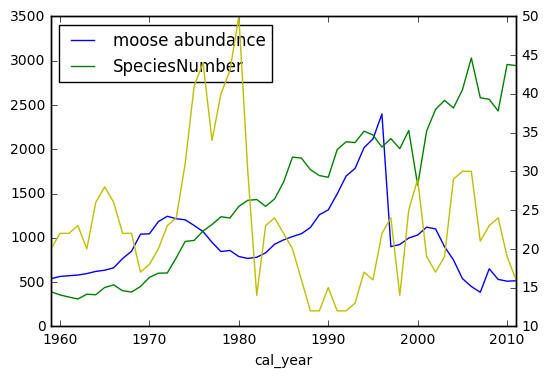

In [21]:
fig, ax = plt.subplots()
ax2=ax.twinx()
df2[['moose abundance','SpeciesNumber']].plot(ax=ax)
df2['wolf abundance'].plot(ax=ax2,color='y')

# Now let's model this with the Lotke-Volterra Equations

`du/dt =  a*u -   b*u*v `

`dv/dt = -c*v + d*b*u*v`
*  u: number of preys (for example, moose)
*  v: number of predators (for example, wolf)
* a, b, c, d are constant parameters defining the behavior of the population:
  + a is the natural growing rate of moose, when there's no wolf
  + b is the natural dying rate of moose, due to predation
  + c is the natural dying rate of wolves, when there's no moose
  + d is the factor describing how many caught moose let create a new wolf

In [48]:
a =1.3
b = 0.053
c = .15
d = 0.01
def dX_dt(X, t, a,b,c,d):
    """ Return the growth rate of wolf and moose populations. """
    u,v = X
    return np.array([ a*u -   b*u*v ,  
                  -c*v + d*b*u*v ])

In [49]:
t = np.linspace(df.index[0], df.index[-1],500)              # time

tmeasinds = [np.argmin(np.abs(t-i)) for i in df.index]      # find the indices where t matches measured time

X0 = np.array([df['moose abundance'].values[0],df['wolf abundance'].values[0]])                # initial conditions
X0

array([ 538.15108689,   20.        ])

In [50]:
def dXdtsolve(args_start, moosemeas, wolvesmeas, X0, t, tmeasinds, usenorm=True):
    a,b,c,d = args_start
    X, msg = spi.odeint(dX_dt, X0, t,  args=(a,b,c,d), full_output=True)
    moosemod, wolvesmod = X.T
    moosemod = moosemod[tmeasinds]
    wolvesmod = wolvesmod[tmeasinds]
    
    if usenorm:
        moosemod  /= np.max(moosemod)
        wolvesmod  /= np.max(wolvesmod)
        moosemeas /= np.max(moosemeas)
        wolvesmeas /= np.max(wolvesmeas)
        
    allmod = np.array(moosemod+wolvesmod)

    allmeas = np.array(moosemeas+wolvesmeas)
    
    obfun = np.dot(np.array(allmod-allmeas).T,np.array(allmod-allmeas))

    return obfun

In [51]:
#a,b,c,d, = optsol[0]

In [52]:
dXdtsolve([a,b,c,d], df['moose abundance'].values.copy().astype(float),
          df['wolf abundance'].values.copy().astype(float), X0, t, tmeasinds, True)

14.124215880532731

In [53]:
optsol = spo.fmin(dXdtsolve,[a,b,c,d],
                  args=( df['moose abundance'].values.copy().astype(float),
                  df['wolf abundance'].values.copy().astype(float), X0, t, tmeasinds),
                 full_output=True, maxiter=1000)

Optimization terminated successfully.
         Current function value: 3.901325
         Iterations: 270
         Function evaluations: 455


In [54]:
optsol #[ 0.47725056,  0.03795058,  0.22180891,  0.00518111]

(array([ 0.38406634,  0.03133749,  0.27175826,  0.00815874]),
 3.9013248113962327,
 270,
 455,
 0)

In [57]:

a =1.3
b = 0.053
c = .15
d = 0.01
a,b,c,d = optsol[0]
#a,b,c,d=[ 0.47725056,  0.03795058,  0.22180891,  0.00518111]
X, infodict = spi.odeint(dX_dt, X0, t,  args=(a,b,c,d), full_output=True)
infodict

{'hu': array([ 0.07616717,  0.07616717,  0.07616717,  0.12719035,  0.12719035,
         0.12719035,  0.12719035,  0.12719035,  0.12719035,  0.12719035,
         0.14433157,  0.14433157,  0.14433157,  0.14433157,  0.14433157,
         0.14433157,  0.14433157,  0.14433157,  0.20708817,  0.20708817,
         0.20708817,  0.20708817,  0.20708817,  0.20708817,  0.20708817,
         0.20708817,  0.20708817,  0.20708817,  0.20708817,  0.20708817,
         0.25260785,  0.25260785,  0.25260785,  0.25260785,  0.25260785,
         0.25260785,  0.25260785,  0.25260785,  0.25260785,  0.25260785,
         0.25260785,  0.25260785,  0.25260785,  0.25260785,  0.25260785,
         0.25260785,  0.25260785,  0.33293072,  0.33293072,  0.33293072,
         0.33293072,  0.33293072,  0.33293072,  0.33293072,  0.33293072,
         0.33293072,  0.33293072,  0.33293072,  0.33293072,  0.33293072,
         0.33293072,  0.33293072,  0.33293072,  0.33293072,  0.33293072,
         0.33293072,  0.33293072,  0.33293072

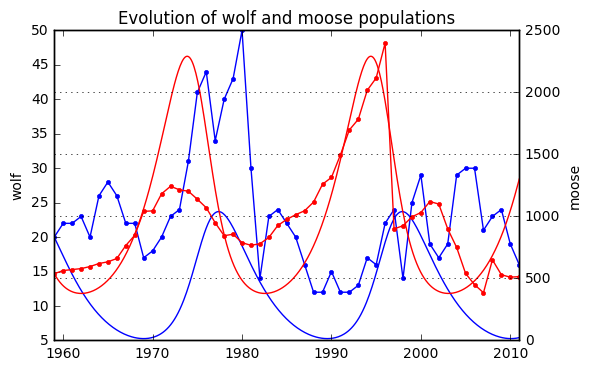

In [56]:
moose, wolves = X.T

fig, ax = plt.subplots()
ax2=ax.twinx()
ax.plot(df.index.values,df['wolf abundance'],label='wolf',marker='.')
ax2.plot(df.index.values,df['moose abundance'],color='r',label='moose',marker='.')
ax2.plot(t, moose, 'r-', label='Moose')
ax.set_ylabel('wolf')
ax.plot(t, wolves  , 'b-', label='Wolves')
plt.ylabel('moose')
#ax2.set_ylim([0, 2500])
plt.xlim([1959, 2011])
plt.grid()
#plt.legend(loc='best')
plt.xlabel('time')
plt.title('Evolution of wolf and moose populations')

### A good start for optimization
`a = 1.3
b = 0.053
c = .15
d = 0.01`

### A good optimal ending point
`a,b,c,d =[ 0.38406634,  0.03133749,  0.27175826,  0.00815874]`